# Imports

In [13]:
# Project setup and imports
import os, sys, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from svgutils.compose import Figure, Panel, SVG
import pickle
from matplotlib import colors as mcolors
from scipy.signal import savgol_filter

# Locate project root and add to path
cwd = Path.cwd()
PROJECT_ROOT = next((p for p in [cwd, *cwd.parents] if (p / 'src').exists()), cwd)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Project-specific imports
from src.simulation import SR_sim
from src.plotting import SR_plotting
import src.sr_utils as utils
import src.correlation_analysis as ca
import src.twin_analysis as ta
import src.gamma_gompertz as gg
from src.HMD_lifetables import HMD
import saved_results.twin_studies_data as td
import saved_results.model_param_calibrations as pc

# Reproducibility setup
SEED = int(os.environ.get('PYTHONHASHSEED', '12345'))
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
RNG = np.random.default_rng(12345)

# Deterministic sampling helpers
def choice_deterministic(a, size=None, replace=True, p=None):
    return RNG.choice(a, size=size, replace=replace, p=p)

def rand_uniform(size=None):
    return RNG.random(size)

# Matplotlib configuration
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Plot styling
plt.rc('axes', facecolor='white', grid=False)
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=16)
plt.rc('axes', titlesize=28, labelsize=24)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('xtick.major', size=8, width=2.5)
plt.rc('ytick.major', size=8, width=2.5)
plt.rc('xtick.minor', size=5, width=2.5)
plt.rc('ytick.minor', size=5, width=2.5)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=28)

def remove_top_right_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Jupyter extensions
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## importing mortality data

In [10]:
sweden_cohort_f = HMD(country='swe', gender = 'female', data_type = 'cohort')
sweden_cohort_m = HMD(country='swe' , gender = 'male', data_type = 'cohort')
sweden_cohort_b = HMD(country='swe' , gender = 'both', data_type = 'cohort')

sweden_period_m = HMD(country='swe' , gender = 'male', data_type = 'period')
sweden_period_f = HMD(country='swe' , gender = 'female', data_type = 'period')

denmark_cohort_m = HMD(country='dan' , gender = 'male', data_type = 'cohort')
denmark_cohort_f = HMD(country='dan' , gender = 'female', data_type = 'cohort')
denmark_cohort_b = HMD(country='dan' , gender = 'both', data_type = 'cohort')

years = np.arange(1870, 1901, 1)

# Basic Run - no heterogeneity

## SR model

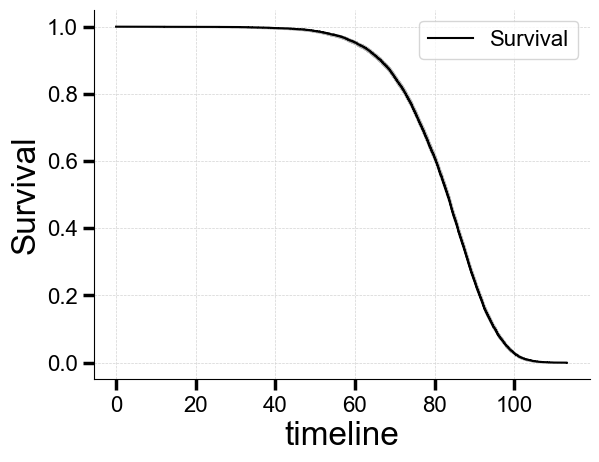

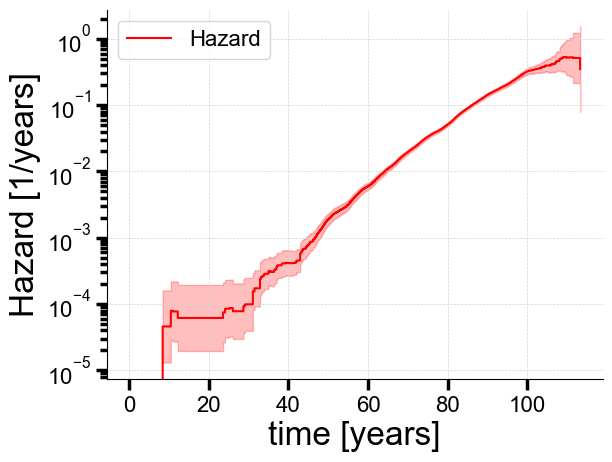

In [2]:
# Demo: Run SR_sim and basic plots
from src.sr_utils import karin_params, create_sr_simulation
from src.plotting import SR_plotting

sim = create_sr_simulation(params_dict=karin_params, n=10000, tmax=120, save_times=0.5, parallel=False)
plotter = SR_plotting(sim)

ax = plotter.plot_survival(color='black', label='Survival')
plotter.plot_hazard(ax=None, color='red', label='Hazard')
plt.show()



## MGG model

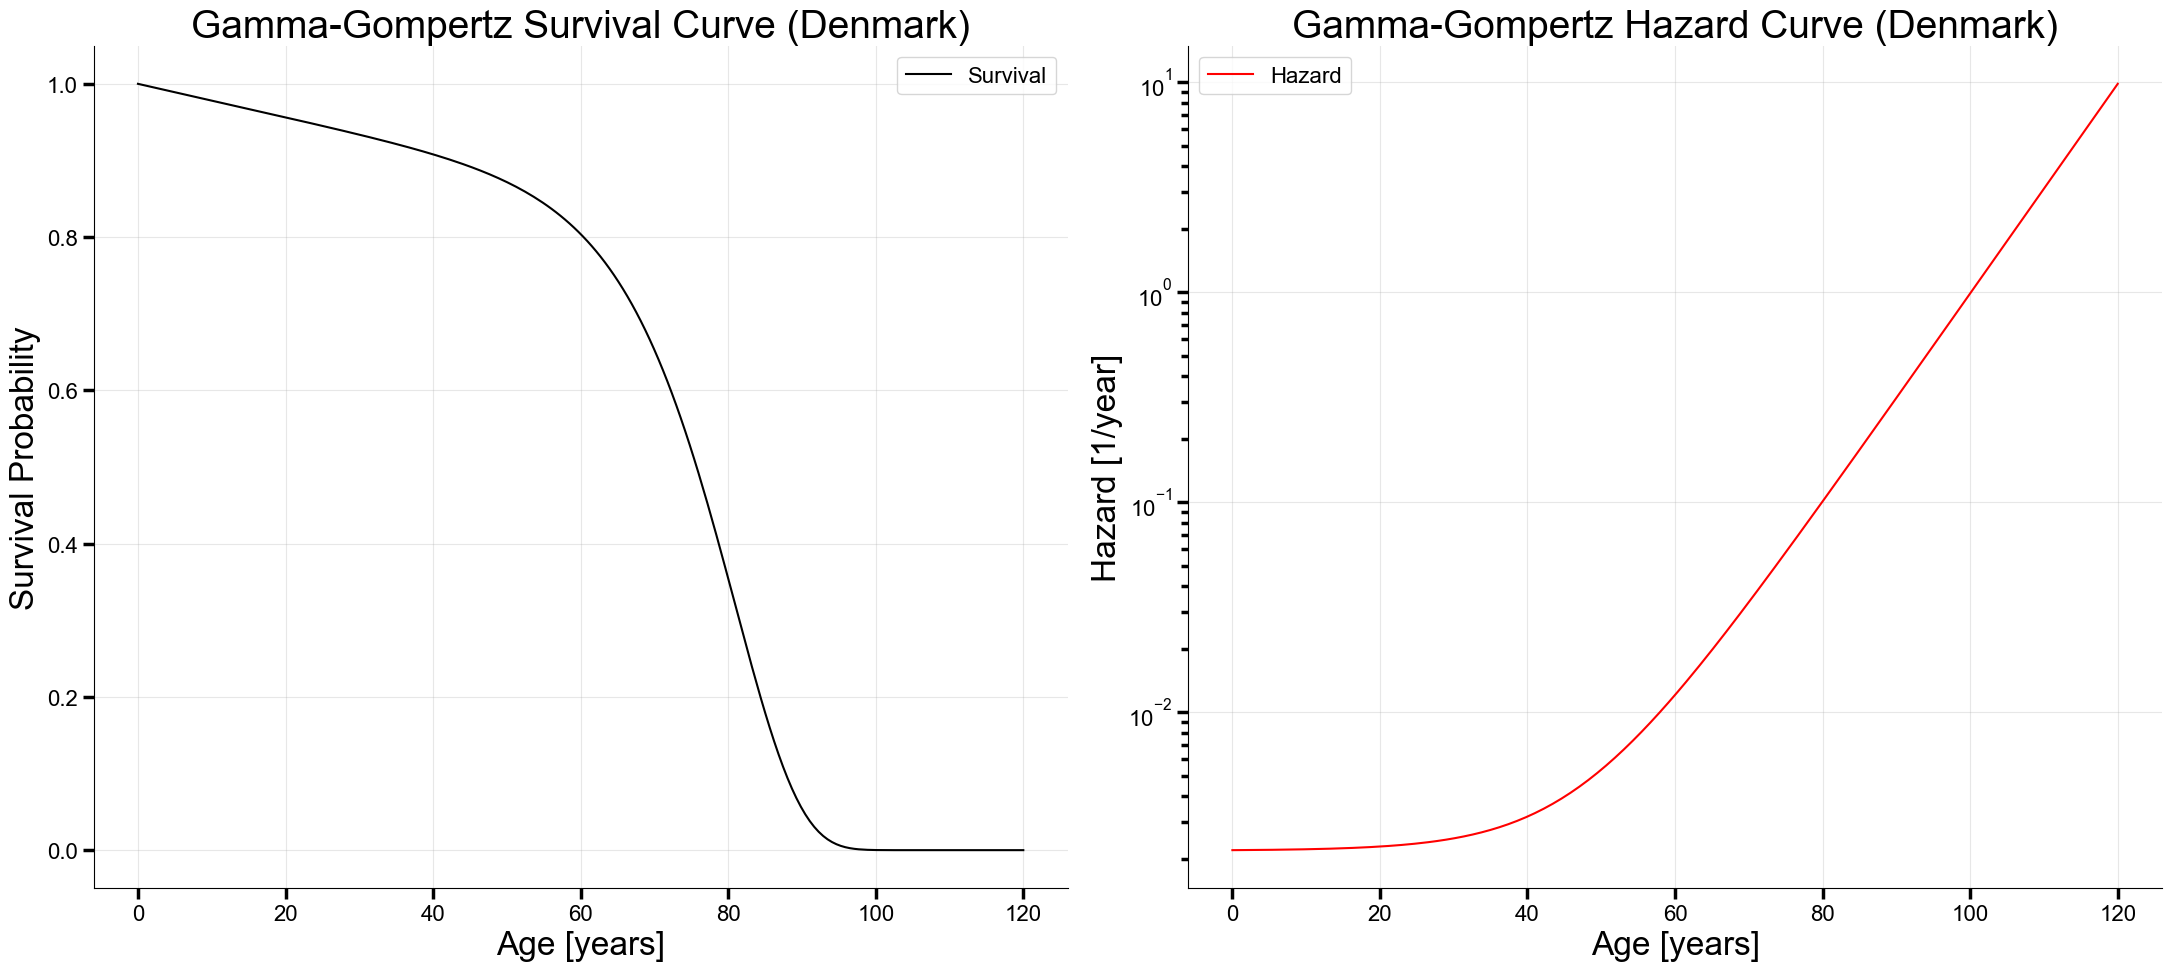

Danish Gamma-Gompertz parameters:
a=1.00e-05 year⁻¹,
b=0.12 year⁻¹,
c = 30,
27% (23%,31%)
m = 2.20e-03 year⁻¹


In [17]:

# Create GG model with Danish parameters
gg_model = gg.GammaGompertz()
gg_model.set_params(pc.mgg_calibrations['denmark'])

# Sample death times
death_times = gg_model.sample_death_times(n=10000, dt=0.5)

# Create survival and hazard plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
# Plot survival curve
ages = np.linspace(0, 120, 200)
_, survival_prob = gg_model.survival_function(ages)
ax1.plot(ages, survival_prob, color='black', label='Survival')
ax1.set_xlabel('Age [years]')
ax1.set_ylabel('Survival Probability')
ax1.set_title('Gamma-Gompertz Survival Curve (Denmark)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot hazard curve
_, hazard = gg_model.calculate_hazard(ages)
ax2.plot(ages, hazard, color='red', label='Hazard')
ax2.set_xlabel('Age [years]')
ax2.set_ylabel('Hazard [1/year]')
ax2.set_yscale('log')
ax2.set_title('Gamma-Gompertz Hazard Curve (Denmark)')
ax2.legend()
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print model parameters
print("Danish Gamma-Gompertz parameters:")
pc.print_calibrated_GG_params('denmark')


# Simulating Danish, Swedish, SATSA cohorts (with heterogeneity)

In [9]:
# Create parameter distributions and simulations for Denmark and Sweden
countries = ['denmark', 'sweden', 'satsa']
sims = {}
plotters = {}
gg_models = {}
death_times_gg = {}

for country in countries:
    # Get parameters
    params = pc.sr_calibrations[country]
    sr_dict = pc.country_dicts[country]
    gg_params = pc.mgg_calibrations[country]
    h_ext = params['m_ex']

    
    # Create SR simulation
    sr_dict = utils.create_param_distribution_dict(
        params_dict=sr_dict,
        params='Xc',
        std=params['Xc_std'], 
        n=int(1e5),
        family='None'
    )
    
    sim = utils.create_sr_simulation(
        params_dict=sr_dict,
        parallel=True,
        tmax=140,
        n=int(1e5),
        h_ext=h_ext,
        break_early=True
    )
    sims[country] = sim
    plotters[country] = SR_plotting(sim)
    
    # Create GG simulation
    gg_model = gg.GammaGompertz()
    gg_model.a = gg_params['a']
    gg_model.b = gg_params['b']
    gg_model.c = gg_params['c']
    gg_model.m = gg_params['m']
    gg_models[country] = gg_model
    
    death_times_gg[country], _ = gg_model.sample_death_times_with_random_param(
        n=100000,
        param_name='b',
        coupled_ab=True,
        std=gg_params['std'], 
        dt=0.05
    )



R^2 values between data and models (ages 20-100):
Denmark - SR model: 0.996, GG model: 0.983
Sweden - SR model: 0.989, GG model: 0.976


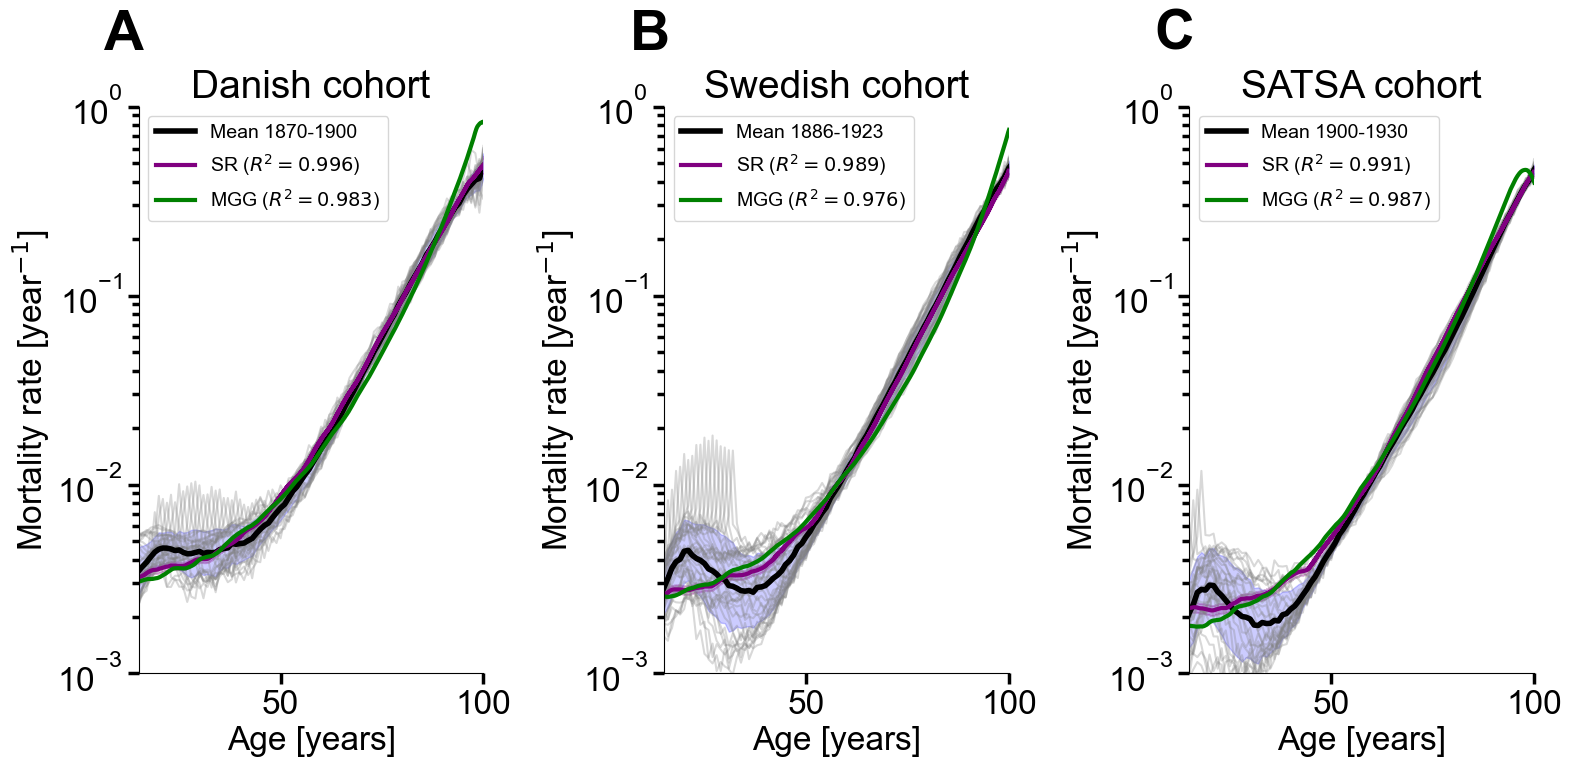

In [12]:
from lifelines import NelsonAalenFitter
from sklearn.metrics import r2_score
# Create figure
fig, axes = plt.subplots(1, 3, figsize=(16, 8))

# Add subplot labels (a) and (b)
axes[0].text(-0.1, 1.1, 'A', transform=axes[0].transAxes, 
             fontsize=40, fontweight='bold', fontname='Arial')
axes[1].text(-0.1, 1.1, 'B', transform=axes[1].transAxes, 
             fontsize=40, fontweight='bold', fontname='Arial')
axes[2].text(-0.1, 1.1, 'C', transform=axes[2].transAxes, 
             fontsize=40, fontweight='bold', fontname='Arial')

# Function to plot hazard comparison for a country
def plot_country_hazard(ax, country, years, title):
    # Plot cohort data with individual years
    if country == 'denmark':
        # Plot the log average hazard curve
        denmark_cohort_b.plot_log_average_hazard_curve(years=years, ax=ax, show_individual=True, 
                                                linewidth=4, color='black')
        ages, hazard, _, _ = denmark_cohort_b.log_average_hazard_curve(years)
    else:  # sweden
        # Plot the log average hazard curve
        sweden_cohort_b.plot_log_average_hazard_curve(years=years, ax=ax, show_individual=True, 
                                               linewidth=4, color='black')
        ages, hazard, _, _ = sweden_cohort_b.log_average_hazard_curve(years)
    
    # Plot SR model hazard
    plotters[country].plot_hazard(ax=ax, color='purple', linewidth=3)
    
    # Plot GG model hazard
    timeline = np.arange(0, 140, 0.05)
    naf_gg = NelsonAalenFitter()
    naf_gg.fit(death_times_gg[country], event_observed=np.ones(len(death_times_gg[country])), timeline=timeline)
    ax.plot(timeline, naf_gg.smoothed_hazard_(bandwidth=3).values, color='green', linewidth=3)
    
    # Calculate R^2 values
    mask_data = (ages >= 20) & (ages <= 100)
    hazard_data = hazard[mask_data]
    ages_filtered = ages[mask_data]
    
    # Get SR hazard
    hazard_sr, _ = sims[country]._calc_hazard(timeline=ages)
    hazard_sr_filtered = hazard_sr[mask_data]
    
    # Get GG hazard
    naf_gg_compare = NelsonAalenFitter()
    naf_gg_compare.fit(death_times_gg[country], event_observed=np.ones(len(death_times_gg[country])), timeline=ages)
    hazard_gg = naf_gg_compare.smoothed_hazard_(bandwidth=3).values
    hazard_gg_filtered = hazard_gg[mask_data]
    
    # Calculate R^2 scores
    r2_sr = r2_score(np.log10(hazard_data), np.log10(hazard_sr_filtered))
    r2_gg = r2_score(np.log10(hazard_data), np.log10(hazard_gg_filtered))
    
    # Format plot
    ax.set_yscale('log')
    ax.set_ylim(1e-3, 1e0)
    ax.set_xlim(15, 100)
    ax.set_xlabel('Age [years]', fontsize=24, fontname='Arial')
    ax.set_ylabel('Mortality rate [year$^{-1}$]', fontsize=24, fontname='Arial')
    ax.set_title(title, fontsize=28, fontname='Arial')
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=24)
    
    # Create custom handles and labels for the legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='black', linewidth=4, label=f'Mean {min(years)}-{max(years)}'),
        Line2D([0], [0], color='purple', linewidth=3, label=f'SR ($R^2={r2_sr:.3f}$)'),
        Line2D([0], [0], color='green', linewidth=3, label=f'MGG ($R^2={r2_gg:.3f}$)')
    ]
    
    ax.legend(handles=legend_elements, prop={'size': 14})
    return r2_sr, r2_gg

# Temporarily suppress warnings
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    
    # Plot Denmark
    denmark_years = np.arange(1870, 1901, 1)
    r2_sr_dk, r2_gg_dk = plot_country_hazard(axes[0], 'denmark', denmark_years, 'Danish cohort')

    # Plot Sweden
    sweden_years = np.arange(1886, 1924, 1)
    r2_sr_se, r2_gg_se = plot_country_hazard(axes[1], 'sweden', sweden_years, 'Swedish cohort')

    satsa_years = np.arange(1900, 1931, 1)
    r2_sr_sa, r2_gg_sa = plot_country_hazard(axes[2], 'satsa', satsa_years, 'SATSA cohort')
plt.tight_layout()

# Save high quality figure
#plt.savefig('figs1.png', dpi=300, bbox_inches='tight')

# Print results
print("\nR^2 values between data and models (ages 20-100):")
print(f"Denmark - SR model: {r2_sr_dk:.3f}, GG model: {r2_gg_dk:.3f}")
print(f"Sweden - SR model: {r2_sr_se:.3f}, GG model: {r2_gg_se:.3f}")

# Asymptotic Heritability

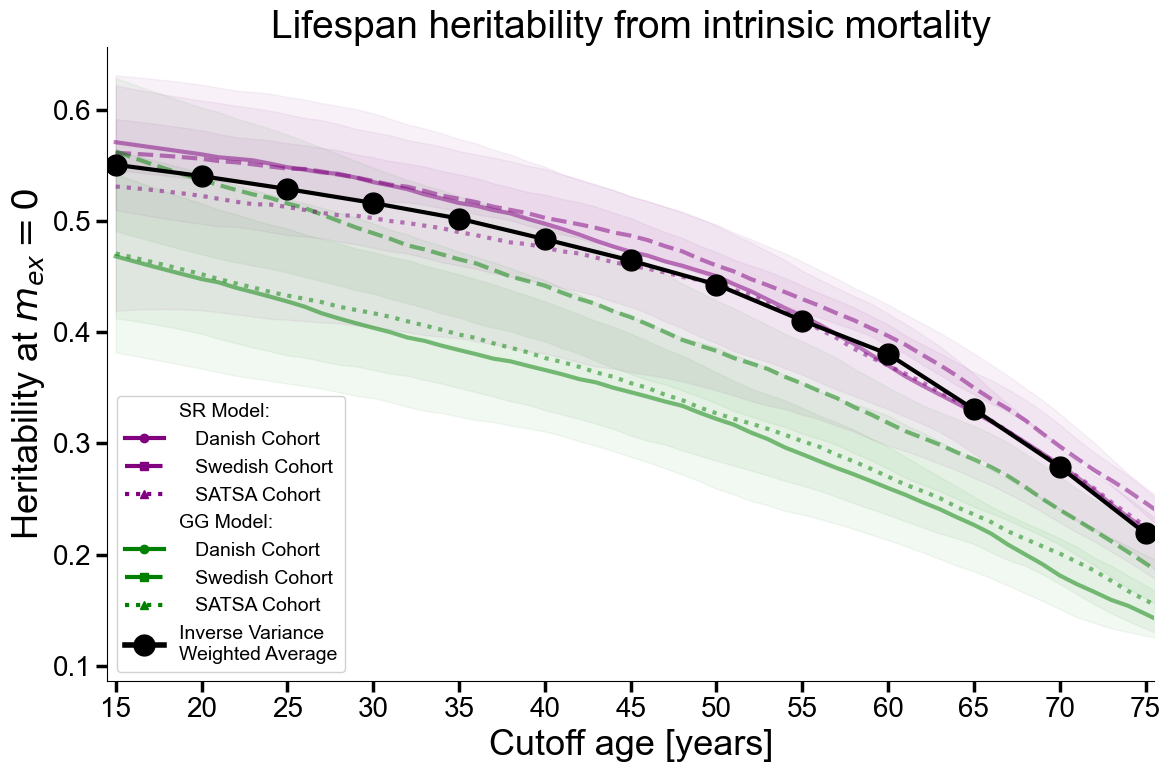

In [13]:
from scipy.signal import savgol_filter
from matplotlib.lines import Line2D

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Define the age range for x-axis
age_range = np.arange(15, 80, 1)  # From 15 to 55 years

# Get heritability values for h_ext = 1e-30 (asymptotic value)
log10h_ext = -30  # Asymptotic value
cohorts = ['danish', 'swedish', 'satsa']
models = ['SR', 'GG']
colors = {'SR': 'purple', 'GG': 'green'}
line_styles = {'danish': '-', 'swedish': '--', 'satsa' : ':'}
markers = {'danish': 'o', 'swedish': 's', 'satsa': '^'}  # Circle for Danish, Square for Swedish, Triangle for SATSA

# Initialize data dictionaries
h2_values = {cohort: {model: [] for model in models} for cohort in cohorts}
h2_lower = {cohort: {model: [] for model in models} for cohort in cohorts}
h2_upper = {cohort: {model: [] for model in models} for cohort in cohorts}

# Calculate heritability for each age, model, and cohort
for age in age_range:
    for cohort in cohorts:
        for model in models:
            h2_result = pc.get_correlation_value(model=model, filter_age=age, log10h_ext=log10h_ext, metric='h2', cohort=cohort)
            h2_parts = h2_result.replace('(', '').replace(')', '').split()
            h2_values[cohort][model].append(float(h2_parts[0]))
            h2_lower[cohort][model].append(float(h2_parts[1].strip(',')))
            h2_upper[cohort][model].append(float(h2_parts[2]))

# Smooth the data if needed
smooth = True  # Set to True to enable smoothing
if smooth:
    for cohort in cohorts:
        for model in models:
            h2_values[cohort][model] = savgol_filter(h2_values[cohort][model], 11, 2)
            h2_lower[cohort][model] = savgol_filter(h2_lower[cohort][model], 11, 2)
            h2_upper[cohort][model] = savgol_filter(h2_upper[cohort][model], 11, 2)

# Plot the heritability curves
for cohort in cohorts:
    for model in models:
        # Plot line with markers every 5 years
        marker_indices = [i for i, age in enumerate(age_range) if age % 5 == 0]
        ax.plot(age_range, h2_values[cohort][model], line_styles[cohort], 
                color=colors[model], linewidth=3, alpha = 0.5)
        #ax.plot(age_range[marker_indices], np.array(h2_values[cohort][model])[marker_indices], 
         #       markers[cohort], color=colors[model], markersize=10)
        
        ax.fill_between(age_range, h2_lower[cohort][model], h2_upper[cohort][model], 
                        color=colors[model], alpha=0.05 if cohort == 'danish' else 0.05)

# Calculate and plot the weighted average heritability across all models and cohorts
# Only calculate for ages at 5-year intervals to match the markers in the other plots
marker_indices = [i for i, age in enumerate(age_range) if age % 5 == 0]
marker_ages = age_range[marker_indices]
weighted_average_h2 = np.zeros_like(marker_ages, dtype=float)
weighted_average_se = np.zeros_like(marker_ages, dtype=float)

for i, age_idx in enumerate(marker_indices):
    values_at_age = []
    variances_at_age = []
    
    for cohort in cohorts:
        for model in models:
            # Get the heritability value
            value = h2_values[cohort][model][age_idx]
            
            # Calculate variance from confidence interval
            # Assuming the CI represents ±1.96*SE (95% CI)
            lower = h2_lower[cohort][model][age_idx]
            upper = h2_upper[cohort][model][age_idx]
            se = (upper - lower) / (2 * 1.96)  # Standard error
            variance = se**2
            
            values_at_age.append(value)
            variances_at_age.append(variance)
    
    # Convert to numpy arrays
    values = np.array(values_at_age)
    variances = np.array(variances_at_age)
    
    # Calculate inverse variance weights
    weights = 1.0 / variances
    
    # Calculate weighted average
    weighted_average_h2[i] = np.sum(weights * values) / np.sum(weights)
    
    # Calculate standard error of weighted average
    weighted_average_se[i] = np.sqrt(1.0 / np.sum(weights))

# Plot the weighted average as a big black circle marker
ax.plot(marker_ages, weighted_average_h2, 
        'o-', color='black', markersize=15, linewidth=3, 
        label='Weighted Average (inverse variance)')

# Set axis labels and title
ax.set_xlabel('Cutoff age [years]', fontsize=26, fontfamily='Arial')
ax.set_xlim(14.5, 75.5)
ax.set_xticks(range(15, 76, 5))
ax.set_ylabel(r'Heritability at $m_{ex}=0$', fontsize=26, fontfamily='Arial')
ax.set_title('Lifespan heritability from intrinsic mortality', fontsize=28, fontfamily='Arial')
ax.tick_params(axis='both', which='major', labelsize=20)

# Create a grouped legend
legend_elements = [
    Line2D([0], [0], color='white', marker='', linestyle='', label='SR Model:'),
    Line2D([0], [0], color=colors['SR'], marker=markers['danish'], linestyle=line_styles['danish'], 
           linewidth=3, markersize=6, label='   Danish Cohort'),
    Line2D([0], [0], color=colors['SR'], marker=markers['swedish'], linestyle=line_styles['swedish'], 
           linewidth=3, markersize=6, label='   Swedish Cohort'),
    Line2D([0], [0], color=colors['SR'], marker=markers['satsa'], linestyle=line_styles['satsa'], 
           linewidth=3, markersize=6, label='   SATSA Cohort'),
    Line2D([0], [0], color='white', marker='', linestyle='', label='GG Model:'),
    Line2D([0], [0], color=colors['GG'], marker=markers['danish'], linestyle=line_styles['danish'], 
           linewidth=3, markersize=6, label='   Danish Cohort'),
    Line2D([0], [0], color=colors['GG'], marker=markers['swedish'], linestyle=line_styles['swedish'], 
           linewidth=3, markersize=6, label='   Swedish Cohort'),
    Line2D([0], [0], color=colors['GG'], marker=markers['satsa'], linestyle=line_styles['satsa'], 
           linewidth=3, markersize=6, label='   SATSA Cohort'),
    Line2D([0], [0], color='black', linestyle='-', marker='o', markersize=15, linewidth=4, label='Inverse Variance\nWeighted Average')
]

ax.legend(handles=legend_elements, fontsize=14, loc='lower left', framealpha=0.9)
ax.grid(False)

# Adjust layout and save
plt.tight_layout()
#plt.savefig('figs5.png', dpi=600, format='png', bbox_inches='tight')
plt.show()

# Non-linear Cutoff Age

In [8]:
# Load Swedish data

with open(os.path.join(PROJECT_ROOT, 'saved_results', 'swedish_GG_correlation_matrices.pkl'), 'rb') as f:
    swedish_gg_correlation_matrices = pickle.load(f)
    
with open(os.path.join(PROJECT_ROOT, 'saved_results', 'swedish_SR_correlation_matrices.pkl'), 'rb') as f:
    swedish_sr_correlation_matrices = pickle.load(f)

# Load Danish data    
with open(os.path.join(PROJECT_ROOT, 'saved_results', 'danish_GG_correlation_matrices.pkl'), 'rb') as f:
    danish_gg_correlation_matrices = pickle.load(f)
    
with open(os.path.join(PROJECT_ROOT, 'saved_results', 'danish_SR_correlation_matrices.pkl'), 'rb') as f:
    danish_sr_correlation_matrices = pickle.load(f)
    
# Load SATSA data
with open(os.path.join(PROJECT_ROOT, 'saved_results', 'satsa_GG_correlation_matrices.pkl'), 'rb') as f:
    satsa_gg_correlation_matrices = pickle.load(f)
    
with open(os.path.join(PROJECT_ROOT, 'saved_results', 'satsa_SR_correlation_matrices.pkl'), 'rb') as f:
    satsa_sr_correlation_matrices = pickle.load(f) 

filtered_ages = pc.filtered_ages
h_exts = pc.h_exts


In [10]:
def plot_metric_vs_extrinsic_mortality(ax, cohort='danish', model='sr', metric='h2', min_age = 15, max_age = 60, colorbar_fontsize=20):
    def get_color_from_age(age, min_age, max_age):
        # Ensure max_age > min_age to avoid division by zero
        safe_max_age = max(min_age + 1, max_age)
        
        # Calculate normalized value between 0 and 1
        normalized = (age - min_age) / (safe_max_age - min_age)
        # Clamp the value between 0 and 1
        normalized = max(0, min(1, normalized))
        # If normalized is exactly 1, make it slightly less to avoid potential issues
        if normalized == 1:
            normalized = 0.999
        return normalized  # Will be used with colormap

    filtered_ages_subset = np.arange(min_age, max_age+1, 5)

    # Select the appropriate correlation matrices based on cohort and model
    if cohort == 'danish':
        if model == 'sr':
            correlation_matrices = danish_sr_correlation_matrices
        elif model == 'mgg':
            correlation_matrices = danish_gg_correlation_matrices
    elif cohort == 'swedish':
        if model == 'sr':
            correlation_matrices = swedish_sr_correlation_matrices
        elif model == 'mgg':
            correlation_matrices = swedish_gg_correlation_matrices
    elif cohort == 'satsa':
        if model == 'sr':
            correlation_matrices = satsa_sr_correlation_matrices
        elif model == 'mgg':
            correlation_matrices = satsa_gg_correlation_matrices

    # Add light grey shaded region
    ax.add_patch(plt.Rectangle((-5, 0), 2, 0.6, color='lightgrey', alpha=0.3, zorder=0))
    ax.add_patch(plt.Rectangle((-3, 0), 1, 0.6, color='grey', alpha=0.3, zorder=0))

    # Create colormap
    cmap = plt.cm.Spectral_r  # Using the reversed version of Spectral
    norm = mcolors.Normalize(vmin=min_age, vmax=max_age)

    # Plot theoretical curves with smoothing
    for age in filtered_ages_subset:
        age_idx = np.where(pc.filtered_ages == age)[0][0]
        normalized_value = get_color_from_age(age, min_age, max_age)
        color = cmap(normalized_value)
        
        # Get the appropriate metric data
        if metric == 'h2':
            # Calculate heritability from MZ and DZ correlations (Falconer's formula)
            y_values = 2 * (correlation_matrices['mz'][age_idx, :] - correlation_matrices['dz'][age_idx, :])
        elif metric == 'mz':
            # Use MZ correlations directly
            y_values = correlation_matrices['mz'][age_idx, :]
        elif metric == 'dz':
            # Use DZ correlations directly
            y_values = correlation_matrices['dz'][age_idx, :]
        
        # Apply Savitzky-Golay smoothing
        smoothed_values = savgol_filter(y_values, window_length=7, polyorder=2)
        
        # Plot the line (without dots, thicker line)
        ax.plot(np.log10(pc.h_exts), smoothed_values, '-', color=color, linewidth=2.5, label=f'Age = {age:.1f}')

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Cutoff Age [years]', rotation=270, labelpad=35, fontsize=colorbar_fontsize, fontname='Arial')
    cbar.ax.tick_params(labelsize=22)

    # Set axis labels and title
    ax.set_xlabel(r'log$_{10}$ $m_{ex}$ extrinsic mortality [year$^{-1}$]')
    ax.set_ylabel(r'Heritability')

    # Set axis limits
    ax.set_xlim(-5, -1.985)
    ax.set_ylim(0, 0.6)

    # No grid
    ax.grid(False)

    # Add explanatory text
    ax.text(
        -4.95, 0.02, 
        "High cutoff age \nreduces heritability",
        fontsize=18, 
        fontfamily='Arial'
    )

    # Add explanatory text
    ax.text(
        -2.95, 0.02, 
        "High cutoff age \nincreases heritability",
        fontsize=18, 
        fontfamily='Arial'
    )
    ax.set_title("Cutoff age has a \nnon-linear effect on heritability", fontfamily='Arial', fontsize = 30, pad = 20)
    
    # Set tick sizes to 20
    ax.tick_params(axis='both', which='major', labelsize=20)


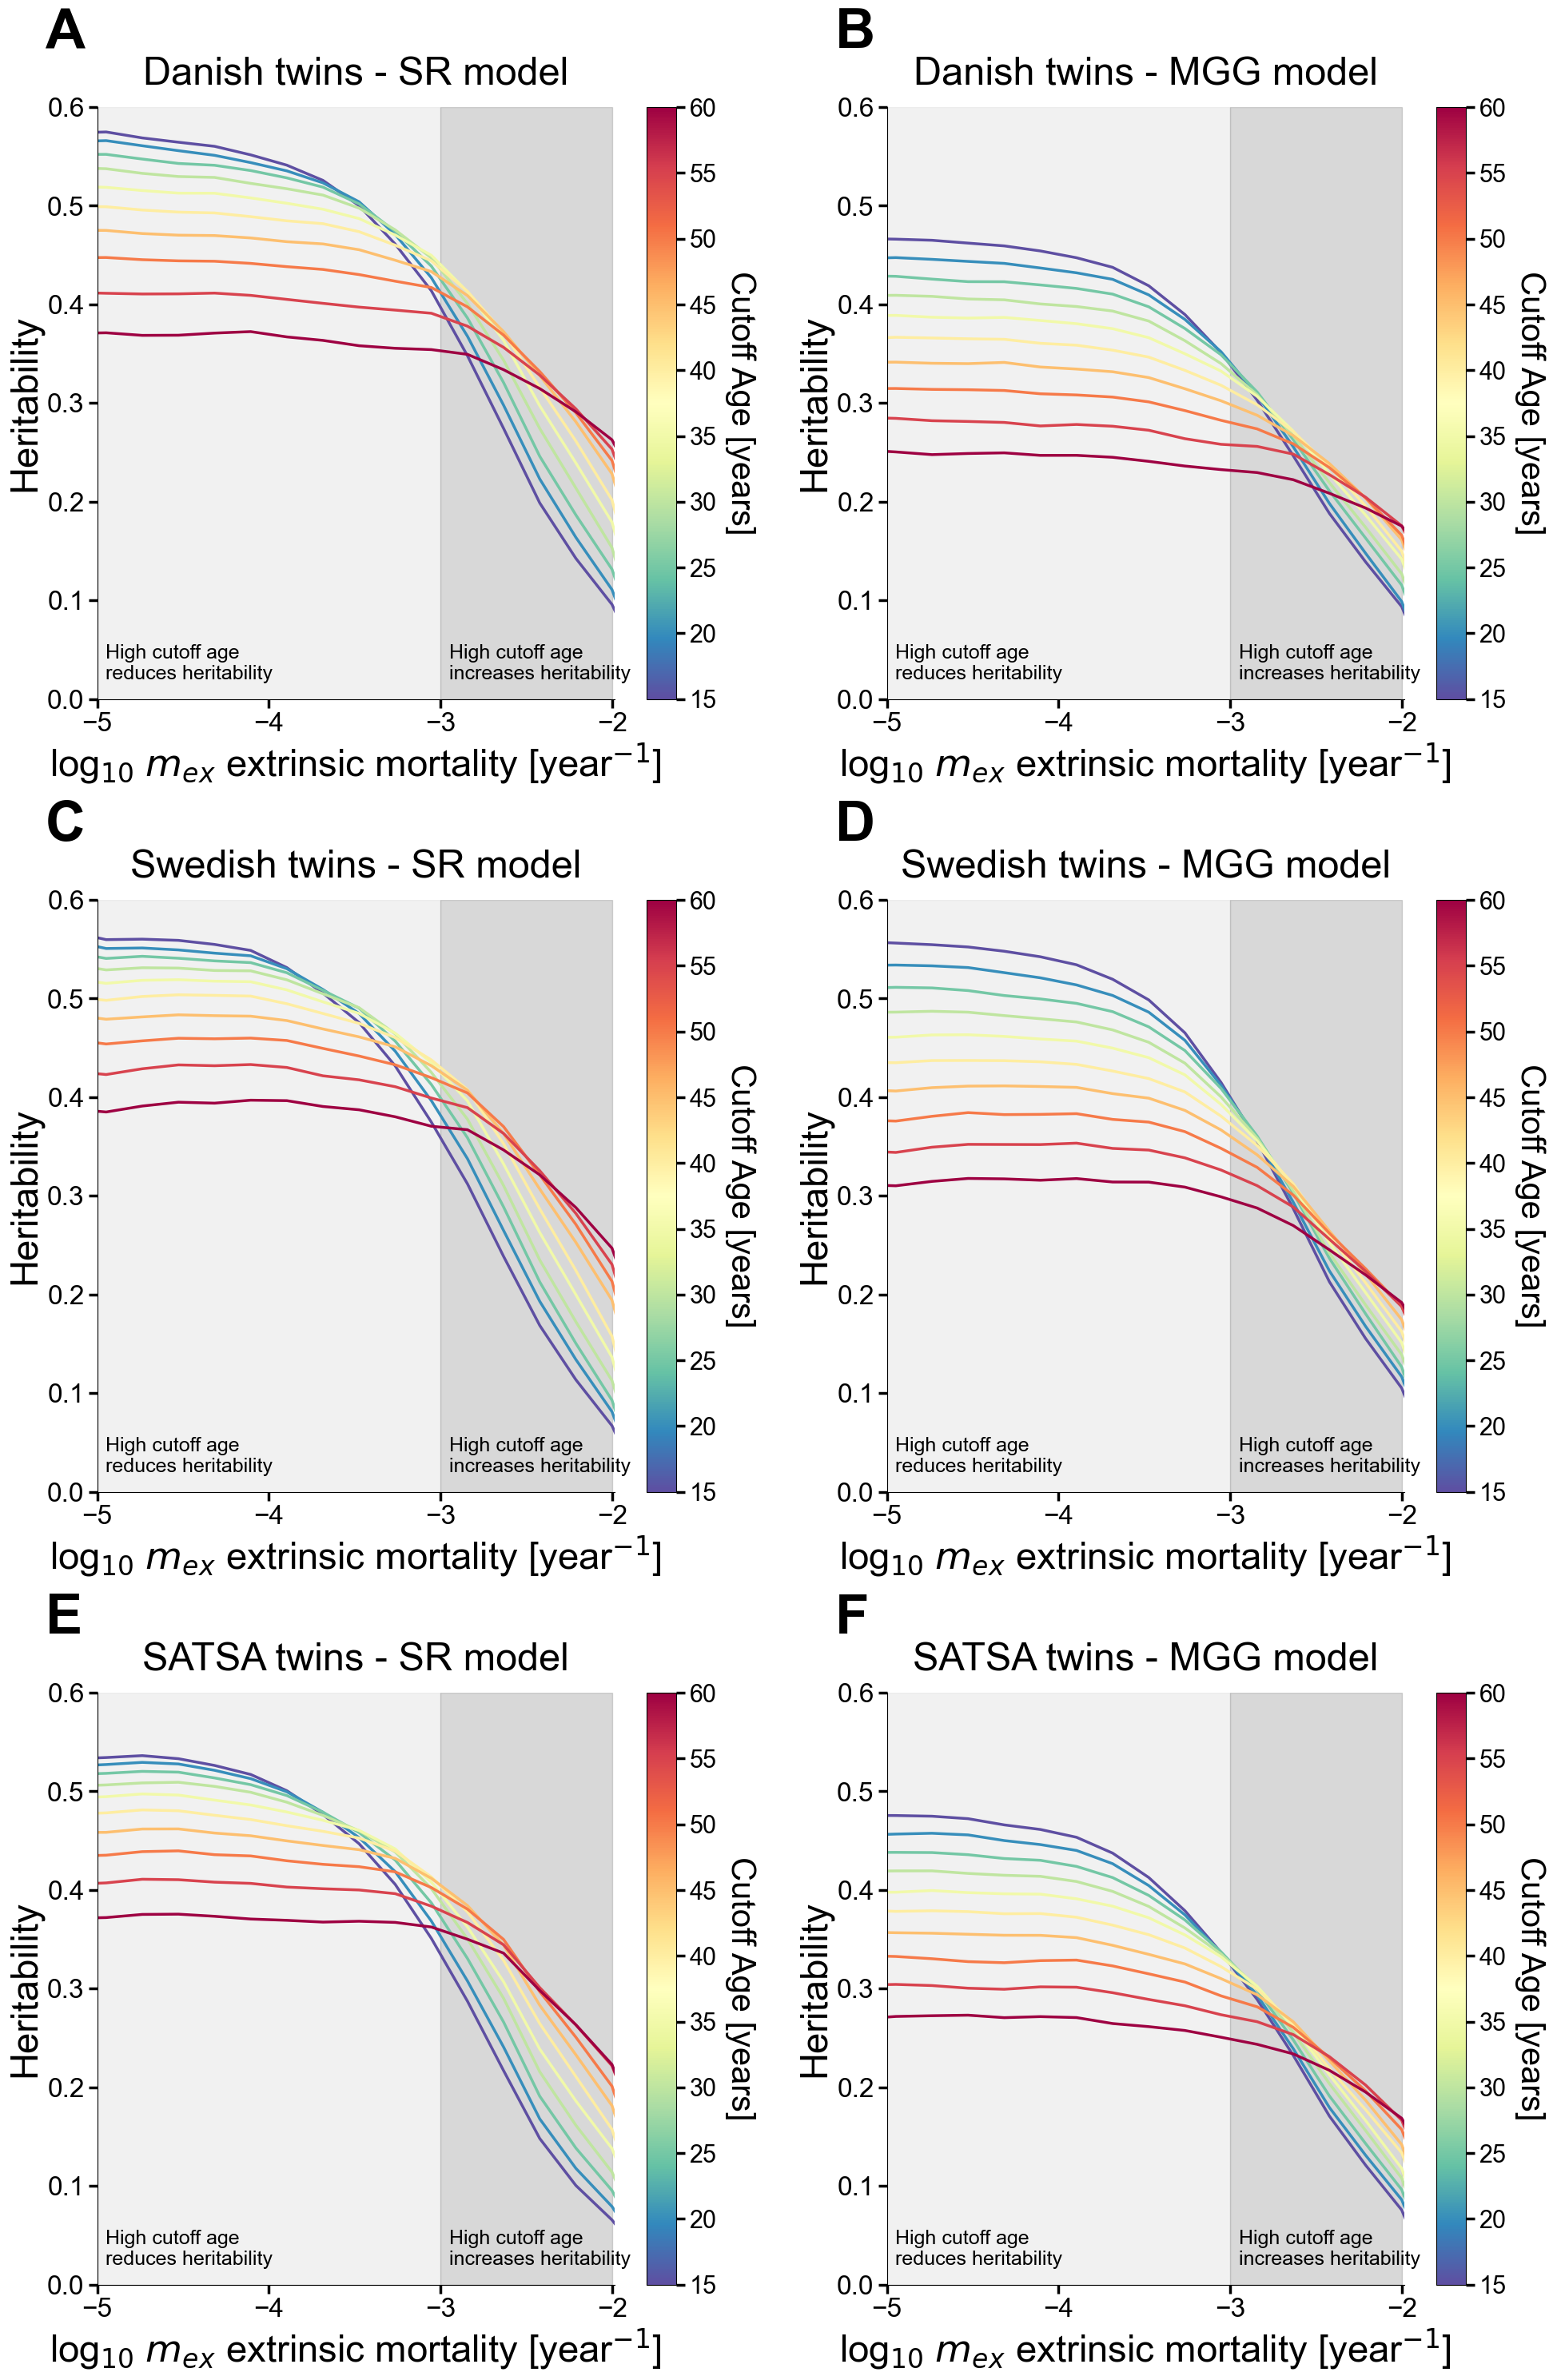

In [14]:
# Create a 3x2 subplot figure with more whitespace between columns
fig, axs = plt.subplots(3, 2, figsize=(20, 30))
plt.subplots_adjust(wspace=0.6)  # Add more whitespace between columns

# Define the combinations of cohort and model
combinations = [
    {'cohort': 'danish', 'model': 'sr', 'title': 'Danish twins - SR model', 'panel': 'A'},
    {'cohort': 'danish', 'model': 'mgg', 'title': 'Danish twins - MGG model', 'panel': 'B'},
    {'cohort': 'swedish', 'model': 'sr', 'title': 'Swedish twins - SR model', 'panel': 'C'},
    {'cohort': 'swedish', 'model': 'mgg', 'title': 'Swedish twins - MGG model', 'panel': 'D'},
    {'cohort': 'satsa', 'model': 'sr', 'title': 'SATSA twins - SR model', 'panel': 'E'},
    {'cohort': 'satsa', 'model': 'mgg', 'title': 'SATSA twins - MGG model', 'panel': 'F'}
]

# Plot each combination in its respective subplot
for i, combo in enumerate(combinations):
    row = i // 2
    col = i % 2
    plot_metric_vs_extrinsic_mortality(
        axs[row, col], 
        cohort=combo['cohort'], 
        model=combo['model'],
        metric='h2',
        colorbar_fontsize=30
        )
    # Set title without panel letter
    axs[row, col].set_title(f"{combo['title']}", fontfamily='Arial', fontsize=35, pad=20)
    
    # Add subplot labels
    axs[row, col].text(-0.1, 1.1, combo['panel'], transform=axs[row, col].transAxes, 
                       fontsize=50, fontweight='bold', fontname='Arial')
    
    # Set font size for axis labels
    axs[row, col].tick_params(axis='both', which='major', labelsize=24)
    axs[row, col].xaxis.label.set_fontsize(34)
    axs[row, col].yaxis.label.set_fontsize(34)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
